In [1]:
!pip install transformers torch datasets transformers[torch]

from google.colab import drive
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
from transformers import AutoTokenizer
import json
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 13.5 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/'

def json_to_df(file_name):
    with open(file_path+file_name, 'r', encoding='utf-8') as f:
        data = json.load(f)

    #json to DataFrame
    df = pd.json_normalize(data, record_path = ['sentences'], meta=['id'], record_prefix='sent_')

    # 불필요한 column 제거
    df = df.drop(columns = ['sent_id', 'sent_speaker', 'sent_intensity_sum', 'sent_is_immoral',
                            'sent_text', 'sent_intensity', 'sent_votes', 'sent_frame_id', 'sent_mapped_slots'])

    # 오타 제거, column 명 수정, 인덱스 초기화
    df.columns = ['text', 'label', 'id']
    df['text'] = df['text'].str.replace('\\','')

    #멀티 레이블 문장 삭제, 정수 변환
    for i in range(len(df)):
        if len(df['label'][i]) != 1:
            df.drop([i], inplace=True)
        elif 'IMMORAL_NONE' in df['label'][i]:
            df['label'][i] = 0
        elif 'CENSURE' in df['label'][i]:
            df['label'][i] = 1
        elif 'DISCRIMINATION' in df['label'][i]:
            df['label'][i] = 2
        elif 'HATE' in df['label'][i]:
            df['label'][i] = 3
        elif 'VIOLENCE' in df['label'][i]:
            df['label'][i] = 4
        elif 'CRIME' in df['label'][i]:
            df['label'][i] = 5
        elif 'SEXUAL' in df['label'][i]:
            df['label'][i] = 6
        elif 'ABUSE' in df['label'][i]:
            df['label'][i] = 7

    return df

merged_df = pd.DataFrame()

for i in range(1, 7):
    merged_df = pd.concat([merged_df, json_to_df(f'talksets-train-{i}.json')])

merged_df.reset_index(drop=True, inplace=True)
merged_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-1349835c10b3>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-3-1349835c10b3>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-3-1349835c10b3>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-3-1349835c10b3>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single

,text,label,id
0,부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네,1,615281b0aab10bca18a468e2
1,맞아. 사람들이 진짜 개념이없다,1,615281b0aab10bca18a468e2
2,저렇게는 살지 말아야지,1,615281b0aab10bca18a468e2
3,그러게 게으르고 멍청한 사람들은 맞아야해,1,615281b0aab10bca18a468e2
4,인방 보는 남자는 거르는게 맞다,1,615281c2aab10bca18a4b716
...,...,...,...
314279,저런 애들을 뽑아주기라도 하겠음? 그냥 실패의 맛 보러 나온거 아님? ㅋ,1,615fc7badcbfe5fa32e8b601
314280,저 여자는 오늘도 레깅스 입네,0,615fc389dcbfe5fa32e7941c
314281,남자 아래에 깔려서 당하고 싶은건가?,4,615fc389dcbfe5fa32e7941c
314282,"휴유, 내가 봐준다 뒷태가 끝내주는데!",0,615fc389dcbfe5fa32e7941c


In [4]:
# id를 기준으로 한 데이터에 문장을 2개씩 묶음
for i in range(len(merged_df)):
    try:
        if merged_df['id'][i] == merged_df['id'][i+1]:
            merged_df.at[i, 'text'] = [merged_df['text'][i], merged_df['text'][i+1]]
            # df.at[i, 'label'] = int(df['label'][i])
            merged_df.at[i, 'label'] = [merged_df['label'][i], merged_df['label'][i+1]]
            merged_df.at[i, 'label'] = [float(j) for j in merged_df['label'][i]]
        else:
            merged_df.drop([i], inplace = True)
    except:
        pass

merged_df.reset_index(drop = True, inplace = True)
merged_df.drop(['id'], axis = 1, inplace = True)
merged_df

,text,label
0,"[부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네, 맞아. 사람들이 진짜 개념이없다]","[1.0, 1.0]"
1,"[맞아. 사람들이 진짜 개념이없다, 저렇게는 살지 말아야지]","[1.0, 1.0]"
2,"[저렇게는 살지 말아야지, 그러게 게으르고 멍청한 사람들은 맞아야해]","[1.0, 1.0]"
3,"[인방 보는 남자는 거르는게 맞다, 사회성이 얼마나 떨어지면 그러냐 ㅋㅋㅋ]","[1.0, 1.0]"
4,"[그렇게 따지면 남자 170cm이하도 겨 나오면 안되지, 짜져라 이 돼지 꿀꿀아]","[1.0, 1.0]"
...,...,...
201813,"[저 나이 쳐먹고는 아이돌 하겠다고 나대는거임? 세상이 잘 돌아간다, 저런 애들을 ...","[1.0, 1.0]"
201814,"[저 여자는 오늘도 레깅스 입네, 남자 아래에 깔려서 당하고 싶은건가?]","[0.0, 4.0]"
201815,"[남자 아래에 깔려서 당하고 싶은건가?, 휴유, 내가 봐준다 뒷태가 끝내주는데!]","[4.0, 0.0]"
201816,"[휴유, 내가 봐준다 뒷태가 끝내주는데!, 저정도면 놀아달라는 거 아닌가? 저 라인...","[0.0, 6.0]"


In [5]:
merged_df.drop([len(merged_df)-1], inplace = True)
merged_df

,text,label
0,"[부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네, 맞아. 사람들이 진짜 개념이없다]","[1.0, 1.0]"
1,"[맞아. 사람들이 진짜 개념이없다, 저렇게는 살지 말아야지]","[1.0, 1.0]"
2,"[저렇게는 살지 말아야지, 그러게 게으르고 멍청한 사람들은 맞아야해]","[1.0, 1.0]"
3,"[인방 보는 남자는 거르는게 맞다, 사회성이 얼마나 떨어지면 그러냐 ㅋㅋㅋ]","[1.0, 1.0]"
4,"[그렇게 따지면 남자 170cm이하도 겨 나오면 안되지, 짜져라 이 돼지 꿀꿀아]","[1.0, 1.0]"
...,...,...
201812,"[그것보다 어떻게 밥그릇 챙기면서 살 수 있을지 고민하는 게 훨씬 이득이지 않아?,...","[1.0, 1.0]"
201813,"[저 나이 쳐먹고는 아이돌 하겠다고 나대는거임? 세상이 잘 돌아간다, 저런 애들을 ...","[1.0, 1.0]"
201814,"[저 여자는 오늘도 레깅스 입네, 남자 아래에 깔려서 당하고 싶은건가?]","[0.0, 4.0]"
201815,"[남자 아래에 깔려서 당하고 싶은건가?, 휴유, 내가 봐준다 뒷태가 끝내주는데!]","[4.0, 0.0]"


In [6]:
merged_df['label'].value_counts(ascending = True)

[5.0, 2.0]        3
[2.0, 5.0]        5
[5.0, 7.0]        9
[7.0, 2.0]       10
[5.0, 3.0]       12
              ...  
[0.0, 3.0]     3153
[1.0, 0.0]    24443
[1.0, 1.0]    30065
[0.0, 1.0]    44161
[0.0, 0.0]    72382
Name: label, Length: 64, dtype: int64

In [7]:
X_train, X_val, y_train, y_val = train_test_split(merged_df['text'], merged_df['label'], test_size=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.055, random_state=0)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(181181, 2)
(10545, 2)
(10091, 2)


In [8]:
binary_ds = DatasetDict({'train': Dataset.from_pandas(train_df), 'val': Dataset.from_pandas(val_df), 'test': Dataset.from_pandas(test_df)})
binary_ds = binary_ds.remove_columns(['__index_level_0__'])
binary_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 181181
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 10091
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10545
    })
})

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # CPU or GPU
print(f'Using {device} device...')

model_ckpt = 'beomi/KcELECTRA-base-v2022'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, sep_token = '[SEP]', cls_token = '[CLS]')

Using cuda device...


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/450k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
tokenizer.tokenize(binary_ds['train']['text'][0])

['한남',
 '##보다는',
 '일',
 '##남이',
 '훨씬',
 '잘',
 '##생겼다',
 '킹',
 '##정',
 '##하는',
 '바',
 '##입니다']

In [11]:
for i in range(len(binary_ds['train']['text'][0])):
    print(tokenizer(binary_ds['train']['text'][0][i]))

{'input_ids': [2, 11211, 9825, 2707, 21085, 9561, 2729, 32609, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [2, 3245, 4100, 7934, 1911, 8034, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokenizer(binary_ds['train']['text'][0][0], binary_ds['train']['text'][0][1], add_special_tokens = True)

{'input_ids': [2, 11211, 9825, 2707, 21085, 9561, 2729, 32609, 3, 3245, 4100, 7934, 1911, 8034, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
# token id 0, 1로 구분되는 토크나이징
# def tokenize_and_encode(data):
#     return tokenizer(data['text'][0],
#                      data['text'][1],
#                      return_tensors = 'pt',
#                      padding = True,
#                      truncation = True,
#                      add_special_tokens = True)

# token id 구분 안되는 토크나이징
def tokenize_and_encode(data):
    return tokenizer(data['text'],
                     return_tensors = 'pt',
                     padding = True,
                     truncation = True,
                     add_special_tokens = True)

cols = binary_ds['train'].column_names
cols.remove('label')
tokenized_ds = binary_ds.map(tokenize_and_encode, remove_columns = cols)
tokenized_ds

Map:   0%|          | 0/181181 [00:00<?, ? examples/s]

Map:   0%|          | 0/10091 [00:00<?, ? examples/s]

Map:   0%|          | 0/10545 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 181181
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10091
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10545
    })
})

In [14]:
tokenized_ds['train'][0]

{'label': [3.0, 0.0],
 'input_ids': [[2, 11211, 9825, 2707, 21085, 9561, 2729, 32609, 3],
  [2, 3245, 4100, 7934, 1911, 8034, 3, 0, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0]]}

In [15]:
tokenized_ds['train']['input_ids'][0]

[[2, 11211, 9825, 2707, 21085, 9561, 2729, 32609, 3],
 [2, 3245, 4100, 7934, 1911, 8034, 3, 0, 0]]

In [16]:
def flat_input(data):
    return dict(input_ids = sum(data['input_ids'], []))
def flat_token(data):
    return dict(token_type_ids = sum(data['token_type_ids'], []))
def flat_attention(data):
    return dict(attention_mask = sum(data['attention_mask'], []))

final_ds = tokenized_ds.map(flat_input, remove_columns = 'input_ids')
final_ds = final_ds.map(flat_token, remove_columns = 'token_type_ids')
final_ds = final_ds.map(flat_attention, remove_columns = 'attention_mask')
final_ds

Map:   0%|          | 0/181181 [00:00<?, ? examples/s]

Map:   0%|          | 0/10091 [00:00<?, ? examples/s]

Map:   0%|          | 0/10545 [00:00<?, ? examples/s]

Map:   0%|          | 0/181181 [00:00<?, ? examples/s]

Map:   0%|          | 0/10091 [00:00<?, ? examples/s]

Map:   0%|          | 0/10545 [00:00<?, ? examples/s]

Map:   0%|          | 0/181181 [00:00<?, ? examples/s]

Map:   0%|          | 0/10091 [00:00<?, ? examples/s]

Map:   0%|          | 0/10545 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 181181
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10091
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10545
    })
})

In [17]:
final_ds.save_to_disk(file_path+'multi_sequence_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/181181 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10091 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10545 [00:00<?, ? examples/s]

In [18]:
test_df.to_csv(file_path+'multi_sequence_testset.csv', encoding = 'utf-8-sig', index = False)

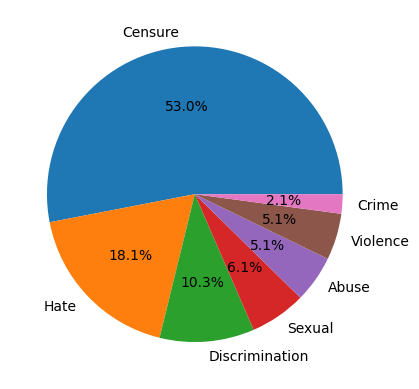

In [19]:
import matplotlib.pyplot as plt

ratio = [205046, 70087, 39997, 23747, 19866, 19634, 8200]
labels = ['Censure', 'Hate', 'Discrimination', 'Sexual', 'Abuse', 'Violence', 'Crime']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()